In [270]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import seaborn as sns
import torch
from torch import optim, nn
from torchvision import models, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torch.nn.functional import one_hot
import torch.nn.functional as F
from sklearn.metrics import ConfusionMatrixDisplay
rng = np.random.default_rng()

In [256]:
n_examples = 500
test_size = 1000
extra_rounds = 100
selected_classes = [i for i in range(10)]

train_path = "./data/mnist_train.csv"
test_path = "./data/mnist_test.csv"

#Note -- place your own MNIST files in the appropriate directory
train_data = np.loadtxt(train_path, delimiter=',')
test_data = np.loadtxt(test_path, delimiter=',')
# In[3]:


train_imgs = train_data[:, 1:]
test_imgs = test_data[:, 1:]
train_labels = train_data[:, 0]
test_labels = test_data[:, 0]

In [226]:
model_path = 'mnist_cnn.pt'
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        embedding = torch.flatten(x, 1)
        x = self.fc1(embedding)
        x = F.relu(x)
        fc1_out = self.dropout2(x)
        x = self.fc2(fc1_out)
        output = F.log_softmax(x, dim=1)
        return output, embedding, fc1_out


# Change the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
cnn = CNN()
cnn.load_state_dict(torch.load(model_path))
cnn.eval()



CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [227]:
def k_cap(input, cap_size):
	output = np.zeros_like(input)
	if len(input.shape) == 1:
		idx = np.argsort(input)[-cap_size:]
		output[idx] = 1
	else:
		idx = np.argsort(input, axis=-1)[:, -cap_size:]
		np.put_along_axis(output, idx, 1, axis=-1)
	return output

In [244]:
n_in = 128
n_neurons = 2000
cap_size = 200
sparsity = 0.1
n_rounds = 15
beta = 1

In [251]:
from scipy.signal import convolve

# for each class load and preprocess 5000 images
examples = np.zeros((10, n_examples, n_in))

for i in range(10):
    tmp = test_imgs[test_labels == i][:n_examples].reshape(-1, 28, 28)
    tmp = torch.from_numpy(tmp).unsqueeze_(1)
    out, emb, fc1 = cnn(tmp.float())
    examples[i] = fc1.detach().numpy()
# 	examples[i] = k_cap(convolve(train_imgs[train_labels == i][:n_examples].reshape(-1, 28, 28), np.ones((1, 3, 3)), mode='same').reshape(-1, 28 * 28), cap_size)


In [283]:
def train_predict(selected_classes, extra_rounds):
    # construct an erdos renyi graph (brain area) and normalize the synaptic weights
    mask = (rng.random((n_neurons, n_neurons)) < sparsity) & np.logical_not(np.eye(n_neurons, dtype=bool))
    W = np.ones((n_neurons, n_neurons)) * mask
    W /= W.sum(axis=0)
    # construct the stimulus area
    mask_a = rng.random((n_in, n_neurons)) < sparsity
    A = np.ones((n_in, n_neurons)) * mask_a
    A /= A.sum(axis=0)


    W = np.ones_like(W) * mask
    A = np.ones_like(A) * mask_a
    W /= W.sum(axis=0, keepdims=True)
    A /= A.sum(axis=0, keepdims=True)
    bias = np.zeros(n_neurons)
    b = -1

    # for each class show a few samples. After each class is shown renormalize the weights. Training time
    overlaps = []
    # train phase
    activations = np.zeros((10, n_rounds, n_neurons), dtype=int)
    act_stimulus = np.zeros((10, n_neurons), dtype=int)
    for idx, i in enumerate(selected_classes):
        act_h = np.zeros(n_neurons)
        tmp = []
        class_activations = []
        for j in range(n_rounds):
            input = examples[i, j].astype(int)
            act_h_new = k_cap(act_h @ W + input @ A + bias, cap_size)
            # count overlap
            assembly_idx = np.where(act_h_new > 0)[0]
            # class_activations.append(assembly_idx)
            assembly = W[assembly_idx[:,None], assembly_idx[None,:]]
            # activations contains which fired in the brain area. Recurrent connection fire and fire from stimuli
            activations[i, j] = act_h_new.copy()

            A[(input > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
            W[(act_h > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
            act_h = act_h_new

        act_stimulus[i] = k_cap(input @ A, cap_size).astype(int)
        overlaps.append(tmp)
        bias[act_h > 0] += b
        A /= A.sum(axis=0, keepdims=True)
        W /= W.sum(axis=0, keepdims=True)

    # show again the examples without the bias. Reconfigure misclassified weights
    for sample in range(extra_rounds):
        class_activations = []
        for idx, i in enumerate(selected_classes):
            act_h = np.zeros(n_neurons, dtype=int)
            for j in range(n_rounds):
                input = examples[i, sample]
                act_stimulus_new = k_cap(input @ A, cap_size).astype(int)
                act_h_new = k_cap(act_h @ W + input @ A, cap_size).astype(int)
                assembly_idx = np.where(act_h_new > 0)[0]
                assembly = W[assembly_idx[:,None], assembly_idx[None,:]]
                overlap = (np.array(act_h, dtype=bool) & np.array(act_h_new, dtype=bool)).sum()
                other_class = selected_classes[(idx + 1) % len(selected_classes)]
                overlap_curr = act_h_new & activations[i, -1]
                overlap_other = act_h_new & activations[other_class, -1]
                act_h = act_h_new
                # Readjust weights so that the correct assembly will fire and reset activations
                if overlap_other.sum() > overlap_curr.sum():
# 					print(f'mismatch class:{i}, sample:{sample} round:{j}, overlap_curr:{overlap_curr.sum()}, overlap_other:{overlap_other.sum()}')
                    overlap_stimulus_curr = act_stimulus_new & act_stimulus[i]
                    overlap_stimulus_other = act_stimulus_new & act_stimulus[other_class]
                    remaining_other = act_stimulus[other_class] & ~overlap_stimulus_other
                    activated_pixels = np.where(input > 0)[0]
                    A[(input > 0)[:, None] & (overlap_stimulus_other > 0)[None, :]] *= 0.9
                    A[(input > 0)[:, None] & (remaining_other > 0)[None, :]] *= 0.9
                    A[(input > 0)[:, None] & (overlap_stimulus_curr > 0)[None, :]] *= 0.95
                    # clear previous winners
                    act_h = np.zeros(n_neurons, dtype=int)
            A /= A.sum(axis=0, keepdims=True)

    # show examples to the trained area and record the activity
    # outputs[i][j]: for class i and round j for all 5000 examples show which neurons fired 
    outputs = np.zeros((10, n_rounds+1, n_examples, n_neurons), dtype=int)
    for i in selected_classes:
        tmp = []
        for j in range(n_rounds):
            outputs[i, j+1] = k_cap(outputs[i, j] @ W + examples[i] @ A, cap_size)

    confusion_matrix = np.zeros((10, 10), dtype=int)
    # make predictions
    for idx, actual_class in enumerate(selected_classes):
        overlap = np.zeros((10, n_examples, n_neurons), dtype=int)
        for testing_class in selected_classes:
            overlap[testing_class] = outputs[actual_class, -1] & activations[testing_class, -1]
        tmp = overlap.sum(axis=2).reshape(-1)
        overlaps_sum = overlap.sum(axis=2)
        preds = np.argmax(overlaps_sum, axis=0)[extra_rounds:]
        correct  = (preds == actual_class).sum()
        hist, _ = np.histogram(preds, bins=np.arange(11))
        confusion_matrix[actual_class] = hist
# 		print(f'actual_class:{actual_class}, accuracy:{correct}/{n_examples}')
    return confusion_matrix

In [284]:
conf_mat = train_predict(selected_classes, 0)
accuracy = np.diagonal(conf_mat).sum() / (n_examples * 10)
accuracy

0.905

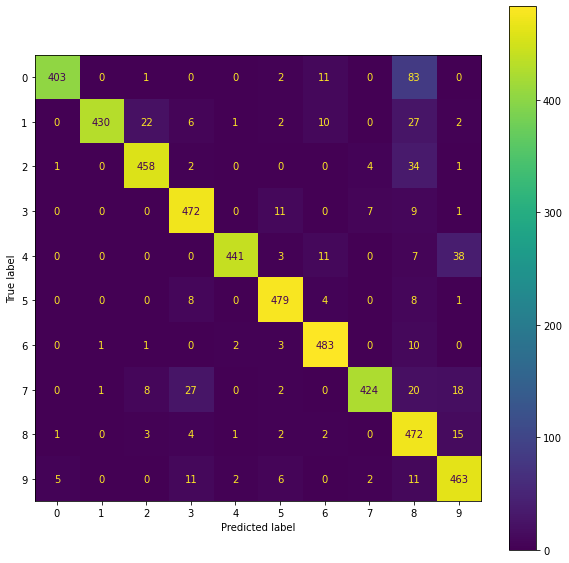

In [285]:
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(ax=ax)